In [1]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
import csv
from scipy.stats import linregress

In [25]:
images = "/Users/David_Sauer/Documents/Biophysik/diffusion-analysis/experiments/tinte-blau-april/pictures/"
areas = images + "areas.csv"
bit_depth = 2**12
dilutions = [500,750,1000,2000,4000,8000]
color_desc = {0: "R", 1: "G", 2: "B", 3: "G"} #read out manually 
raw_pattern = [[0,1], [3,2]]
#FIXME: Use relative path instead

In [108]:
def singleColorArray(target_color, arr, posx, posy):
    if target_color == None:
        return arr.mean()
    new_arr = []
    for index_r, row in enumerate(arr):
        for index_c, col in enumerate(row):
            r_ind = index_r + posy
            c_ind = index_c + posx
            color = None 
            if r_ind % 2 == 0:
                if c_ind % 2 == 0:
                    color = 0
                else:
                    color = 1
            else:
                if c_ind % 2 == 0:
                    color = 3
                else:
                    color = 2
            if color_desc[color] == target_color:
                new_arr.append(col)
            else:
                pass
    return np.array(new_arr)

def read(dilution, x, y, xlen, ylen):
    y = y + y%2
    x = x + x%2
    xlen = xlen + xlen%2
    ylen = ylen + ylen%2
    img_data = None
    with rawpy.imread(images+str(dilution)+".DNG") as raw:
        img_data = raw.raw_image.copy()
        black = np.array(raw.black_level_per_channel).mean()
    ret = img_data[y:y+ylen,x:x+xlen]
    return (ret, black)

def get_boundaries(dilution):
    with open(areas) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0] == str(dilution):
                if row[1] == "NA":
                    raise RuntimeError("Areas not defined.")
                return [int(n) for n in row[1:]]
            
def _intensity(dilution, boundaries, color):
    x, y, xlen, ylen, xctrl, yctrl, xlenctrl, ylenctrl = boundaries
    arr_a, black_a = read(dilution, x, y, xlen, ylen)
    arr_c, black_c = read(dilution, xctrl, yctrl, xlenctrl, ylenctrl)
    a_val = (singleColorArray(color, arr_a, x, y).mean() - black_a)
    c_val = (singleColorArray(color, arr_c, xctrl, yctrl).mean() - black_c)
    print(a_val, c_val)
    print(np.log10(c_val/a_val))
    return (np.log10(c_val/a_val), dilution)

def c_intensity(dilution, color):
    return _intensity(dilution, get_boundaries(dilution), color)[0]

def intensity(dilution):
    #FIXME: Improve performance
    return c_intensity(dilution, None)

9.665840000000003 705.5105068226121
1.8632638839485243
69.08579999999995 721.6419111111111
1.018932956974804
195.70791999999994 487.132876
0.3960390393158413
386.2687111111111 487.4695777777778
0.10105798677995263
459.7021 497.5970666666667
0.034401323837161955
482.4048415584416 443.8991555555556
-0.03612733900952826
R: 0.9716751452636309, p 0.001192083615158403


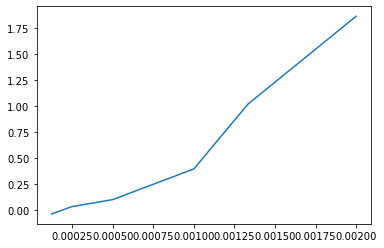

In [112]:
intensities = []
concentrations = []

for dil in dilutions:
    intensities.append(intensity(dil))
    concentrations.append(1/dil)

plt.plot(concentrations[:], intensities[:])
slope, intercept, r_value, p_value, std_err = linregress(concentrations[:], intensities[:])
print("R: {}, p {}".format(r_value, p_value))

R
500
6.453300000000013 719.9309161793371
2.047508968994343
750
43.271433333333334 739.8858666666667
1.2329634503765146
1000
172.63887999999997 492.75795200000005
0.45549503169044236
2000
378.6216888888889 491.4339111111111
0.11325963303776598
4000
465.1056 506.4026666666666
0.03694441539875684
8000
491.68130909090905 453.2135111111111
-0.035380850728433964
R: 0.973580508948198, p 0.0010377639973813847 


G
500
12.762410000000045 903.5759454191034
1.8500319683367727
750
74.33795833333329 927.958311111111
1.0963178366345017
1000
235.41675999999995 625.2911039999999
0.42424487174024605
2000
482.1465511111111 627.619688888889
0.11451749474937145
4000
581.3850124999999 638.5274133333332
0.04071571526163183
8000
613.6639688311689 569.3034666666667
-0.03258679613624372
R: 0.975157611037748, p 0.0009180507647867746 


B
500
6.685240000000022 294.95922027290453
1.6446449734963486
750
84.39585 290.76515555555557
0.5372212691533614
1000
139.35928 205.19134399999996
0.16802314222073306
2000
202.1

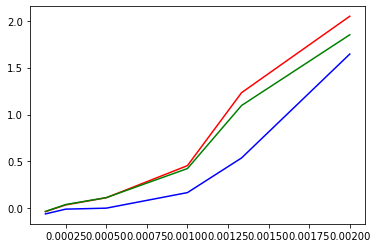

In [111]:
for col in ["R","G","B"]:
    print(col)
    intensities = []
    concentrations = []

    for dil in dilutions:
        print(dil)
        intensities.append(c_intensity(dil, col))
        concentrations.append(1/dil)
    plt.plot(concentrations[:], intensities[:], color=col)
    #FIXME: Before plotting convert to lowercase color letter
    slope, intercept, r_value, p_value, std_err = linregress(concentrations[:], intensities[:])
    print("R: {}, p {} \n\n".format(r_value, p_value))